In [9]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten


In [10]:
data_dir = "./Dataset" # Root folder containing subfolders of each class

# Load dataset from directory
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,image_size=(256,256),batch_size=32,label_mode="categorical"
)

class_names = dataset.class_names


Found 1200 files belonging to 20 classes.


In [11]:
train_size = 0.8
train_ds = dataset.take(int(len(dataset) * train_size))
test_ds = dataset.skip(int(len(dataset) * train_size))

In [12]:
# Prefetch for performance
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

def dataset_to_numpy(dataset):
    images, labels = [], []
    for batch_images, batch_labels in dataset:
        images.append(batch_images.numpy())
        labels.append(batch_labels.numpy())
    return np.concatenate(images), np.concatenate(labels)


In [13]:
# Extract training and testing data
x_train, y_train = dataset_to_numpy(train_ds)
x_test, y_test = dataset_to_numpy(test_ds)

x_train=x_train/255.0
x_test=x_test/255.0

In [14]:
#model architecture
model=Sequential([
    Conv2D(32,(3,3),activation='relu',input_shape=(256,256,3)),
    MaxPooling2D((2,2)),

    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(64,activation='relu'),
    Dense(20,activation='softmax')
])


In [15]:
optim=tf.keras.optimizers.Adam(learning_rate=0.001) 
model.compile(
    loss='categorical_crossentropy',optimizer=optim,metrics=['accuracy']
)

In [19]:
model.fit(x_train,y_train,epochs=5,batch_size=64)

Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8551 - loss: 0.7620
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9470 - loss: 0.3682
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9862 - loss: 0.1616
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9987 - loss: 0.0626
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 1.0000 - loss: 0.0165


In [20]:
model.evaluate(x_test,y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.7222 - loss: 1.4521


[1.563353419303894, 0.7166666388511658]

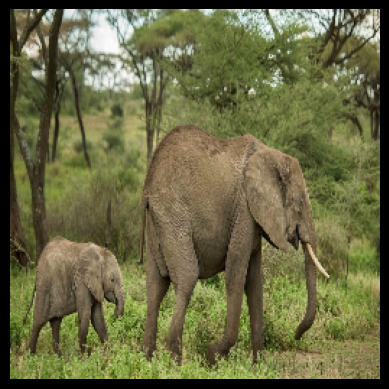

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted class: sheep


In [36]:
idx = random.randint(0, len(y_test))
plt.imshow(x_test[idx, :])
plt.axis('off')
plt.show()

y_pred = model.predict(x_test[idx, :].reshape(1,256,256,3))

predicted_class_index = np.argmax(y_pred)
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted class: {predicted_class_name}")